In [1]:
# Generic imports:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math, random, re
import time
import pickle
from Bio import SeqIO
import multiprocessing
import glob
import os

In [2]:
# Machine learning/Stats imports:
from scipy.stats import norm
from scipy.stats import spearmanr,pearsonr
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras import regularizers
from keras import optimizers
from keras.layers import Input, Dense, Lambda, Dropout, Activation, Bidirectional, RepeatVector, Reshape, LSTM
from keras import backend as K
from keras.engine.topology import Layer
from keras import objectives
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import losses

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

/app/easybuild/software/Python/3.6.3-foss-2016b-fh1/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
class OnehotEmbedding2D(Layer):
    '''
    This is an alternative to the normal keras embedding layer
    which works on categorical data. This provides the same functionality
    but on a onehot encoding of the categorical data.
    '''
    def __init__(self, Nembeddings, **kwargs):
        self.Nembeddings = Nembeddings
        super(OnehotEmbedding2D, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[2], self.Nembeddings),
                                      initializer='uniform',
                                      trainable=True)
        super(OnehotEmbedding2D, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.dot(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.Nembeddings)


In [4]:
# Amino acid alphabet:
AA_ORDER = 'ACDEFGHIKLMNPQRSTVWY-'
AA_LIST = list(AA_ORDER)
AA_DICT = {c:i for i, c in enumerate(AA_LIST)}
AA_DICT_REV = {i:c for i, c in enumerate(AA_LIST)}
AA_SET = set(AA_LIST)


'''
# V genes:
V_GENE_LIST = ['TCRBV01-01', 'TCRBV02-01', 'TCRBV03-01', 'TCRBV03-02', 'TCRBV04-01', 'TCRBV04-02', 'TCRBV04-03',
               'TCRBV05-01', 'TCRBV05-02', 'TCRBV05-03', 'TCRBV05-04', 'TCRBV05-05', 'TCRBV05-06', 'TCRBV05-07',
               'TCRBV05-08', 'TCRBV06-01', 'TCRBV06-04', 'TCRBV06-05', 'TCRBV06-06', 'TCRBV06-07', 'TCRBV06-08',
               'TCRBV06-09', 'TCRBV07-01', 'TCRBV07-02', 'TCRBV07-03', 'TCRBV07-04', 'TCRBV07-05', 'TCRBV07-06',
               'TCRBV07-07', 'TCRBV07-08', 'TCRBV07-09', 'TCRBV08-02', 'TCRBV09-01', 'TCRBV10-01', 'TCRBV10-02',
               'TCRBV10-03', 'TCRBV11-01', 'TCRBV11-02', 'TCRBV11-03', 'TCRBV12-01', 'TCRBV12-02', 'TCRBV12-05',
               'TCRBV13-01', 'TCRBV14-01', 'TCRBV15-01', 'TCRBV16-01', 'TCRBV18-01', 'TCRBV19-01', 'TCRBV20-01',
               'TCRBV21-01', 'TCRBV22-01', 'TCRBV23-01', 'TCRBV23-or09_02', 'TCRBV25-01', 'TCRBV27-01', 'TCRBV28-01',
               'TCRBV29-01', 'TCRBV30-01', 'TCRBVA-or09_02']

### CMV data V gene set:
V_GENE_LIST = ['TCRBV01-01',
 'TCRBV02-01',
 'TCRBV03-01',
 'TCRBV03-02',
 'TCRBV04-01',
 'TCRBV04-02',
 'TCRBV04-03',
 'TCRBV05-01',
 'TCRBV05-02',
 'TCRBV05-03',
 'TCRBV05-04',
 'TCRBV05-05',
 'TCRBV05-06',
 'TCRBV05-07',
 'TCRBV05-08',
 'TCRBV06-01',
 'TCRBV06-04',
 'TCRBV06-05',
 'TCRBV06-06',
 'TCRBV06-07',
 'TCRBV06-08',
 'TCRBV06-09',
 'TCRBV07-01',
 'TCRBV07-02',
 'TCRBV07-03',
 'TCRBV07-04',
 'TCRBV07-05',
 'TCRBV07-06',
 'TCRBV07-07',
 'TCRBV07-08',
 'TCRBV07-09',
 'TCRBV08-02',
 'TCRBV09-01',
 'TCRBV10-01',
 'TCRBV10-02',
 'TCRBV10-03',
 'TCRBV11-01',
 'TCRBV11-02',
 'TCRBV11-03',
 'TCRBV12-01',
 'TCRBV12-02',
 'TCRBV12-05',
 'TCRBV13-01',
 'TCRBV14-01',
 'TCRBV15-01',
 'TCRBV16-01',
 'TCRBV17-01',
 'TCRBV18-01',
 'TCRBV19-01',
 'TCRBV20-01',
 'TCRBV20-or09_02',
 'TCRBV21-01',
 'TCRBV21-or09_02',
 'TCRBV22-01',
 'TCRBV22-or09_02',
 'TCRBV23-01',
 'TCRBV23-or09_02',
 'TCRBV25-01',
 'TCRBV25-or09_02',
 'TCRBV26-01',
 'TCRBV26-or09_02',
 'TCRBV27-01',
 'TCRBV28-01',
 'TCRBV29-01',
 'TCRBV29-or09_02',
 'TCRBV30-01',
 'TCRBVA-or09_02']

V_GENE_DICT = {c:i for i, c in enumerate(V_GENE_LIST)}
V_GENE_DICT_REV = {i:c for i, c in enumerate(V_GENE_LIST)}
V_GENE_SET = set(V_GENE_LIST)

# J genes:
J_GENE_LIST = ['TCRBJ01-01', 'TCRBJ01-02', 'TCRBJ01-03', 'TCRBJ01-04', 'TCRBJ01-05', 'TCRBJ01-06', 'TCRBJ02-01',
               'TCRBJ02-02', 'TCRBJ02-03', 'TCRBJ02-04', 'TCRBJ02-05', 'TCRBJ02-06', 'TCRBJ02-07']
J_GENE_DICT = {c:i for i, c in enumerate(J_GENE_LIST)}
J_GENE_DICT_REV = {i:c for i, c in enumerate(J_GENE_LIST)}
J_GENE_SET = set(J_GENE_LIST)





# HLA:
HLA_LIST = ['HLA-A*01',
 'HLA-A*02',
 'HLA-A*03',
 'HLA-A*11',
 'HLA-A*23',
 'HLA-A*24',
 'HLA-A*25',
 'HLA-A*26',
 'HLA-A*29',
 'HLA-A*30',
 'HLA-A*31',
 'HLA-A*32',
 'HLA-A*33',
 'HLA-A*68',
 'HLA-B*07',
 'HLA-B*08',
 'HLA-B*13',
 'HLA-B*14',
 'HLA-B*15',
 'HLA-B*18',
 'HLA-B*27',
 'HLA-B*35',
 'HLA-B*38',
 'HLA-B*39',
 'HLA-B*40',
 'HLA-B*44',
 'HLA-B*51',
 'HLA-B*57',
 'HLA-B*60',
 'HLA-B*62']
HLA_DICT = {c:i for i, c in enumerate(HLA_LIST)}
HLA_DICT_REV = {i:c for i, c in enumerate(HLA_LIST)}
HLA_SET = set(HLA_LIST)

'''

"\n# V genes:\nV_GENE_LIST = ['TCRBV01-01', 'TCRBV02-01', 'TCRBV03-01', 'TCRBV03-02', 'TCRBV04-01', 'TCRBV04-02', 'TCRBV04-03',\n               'TCRBV05-01', 'TCRBV05-02', 'TCRBV05-03', 'TCRBV05-04', 'TCRBV05-05', 'TCRBV05-06', 'TCRBV05-07',\n               'TCRBV05-08', 'TCRBV06-01', 'TCRBV06-04', 'TCRBV06-05', 'TCRBV06-06', 'TCRBV06-07', 'TCRBV06-08',\n               'TCRBV06-09', 'TCRBV07-01', 'TCRBV07-02', 'TCRBV07-03', 'TCRBV07-04', 'TCRBV07-05', 'TCRBV07-06',\n               'TCRBV07-07', 'TCRBV07-08', 'TCRBV07-09', 'TCRBV08-02', 'TCRBV09-01', 'TCRBV10-01', 'TCRBV10-02',\n               'TCRBV10-03', 'TCRBV11-01', 'TCRBV11-02', 'TCRBV11-03', 'TCRBV12-01', 'TCRBV12-02', 'TCRBV12-05',\n               'TCRBV13-01', 'TCRBV14-01', 'TCRBV15-01', 'TCRBV16-01', 'TCRBV18-01', 'TCRBV19-01', 'TCRBV20-01',\n               'TCRBV21-01', 'TCRBV22-01', 'TCRBV23-01', 'TCRBV23-or09_02', 'TCRBV25-01', 'TCRBV27-01', 'TCRBV28-01',\n               'TCRBV29-01', 'TCRBV30-01', 'TCRBVA-or09_02']\n\n### 

In [277]:
af = {'A': np.array([-0.591, -1.302, -0.733, 1.570, -0.146]),
    'C': np.array([-1.343, 0.465, -0.862, -1.020, -0.255]),
    'D': np.array([1.050, 0.302, -3.656, -0.259, -3.242]),
    'E': np.array([1.357, -1.453, 1.477, 0.113, -0.837]),
    'F': np.array([-1.006, -0.590, 1.891, -0.397, 0.412]),
    'G': np.array([-0.384, 1.652, 1.330, 1.045, 2.064]),
    'H': np.array([0.336, -0.417, -1.673, -1.474, -0.078]),
    'I': np.array([-1.239, -0.547, 2.131, 0.393, 0.816]),
    'K': np.array([1.831, -0.561, 0.533, -0.277, 1.648]),
    'L': np.array([-1.019, -0.987, -1.505, 1.266, -0.912]),
    'M': np.array([-0.663, -1.524, 2.219, -1.005, 1.212]),
    'N': np.array([0.945, 0.828, 1.299, -0.169, 0.933]),
    'P': np.array([0.189, 2.081, -1.628, 0.421, -1.392]),
    'Q': np.array([0.931, -0.179, -3.005, -0.503, -1.853]),
    'R': np.array([1.538, -0.055, 1.502, 0.440, 2.897]),
    'S': np.array([-0.228, 1.399, -4.760, 0.670, -2.647]),
    'T': np.array([-0.032, 0.326, 2.213, 0.908, 1.313]),
    'V': np.array([-1.337, -0.279, -0.544, 1.242, -1.262]),
    'W': np.array([-0.595, 0.009, 0.672, -2.128, -0.184]),
    'Y': np.array([0.260, 0.830, 3.097, -0.838, 1.512]),
    '-': np.array([0.000, 0.000, 0.000, 0.000, 0.000])}

In [5]:
try:
    import jellyfish
    def hamming_distance(s1, s2):
        if s1 == s2:
            return 0
        else:
            return jellyfish.hamming_distance(s1, s2)
except:
    def hamming_distance(seq1, seq2):
        '''Hamming distance between two sequences of equal length'''
        return sum(x != y for x, y in zip(seq1, seq2))

In [279]:
def pack_training_test_data(TCRB_dict, test_fraction=0.1):

    assert(False not in [len(l) % BATCH_SIZE == 0 for l in TCRB_dict.values()])
    Nbatches = sum(len(l) // BATCH_SIZE for l in TCRB_dict.values())
    onehot_seq = np.zeros((BATCH_SIZE*Nbatches, MAX_LEN, len(af['A'])))
    cmv_labels = np.zeros((BATCH_SIZE*Nbatches))

    i = 0
    for subj_id in sorted(TCRB_dict.keys()):
        for tcr in random.choices(TCRB_dict[subj_id], k=len(TCRB_dict[subj_id])):
            for j, a in enumerate(tcr[0]):
                onehot_seq[i][j] = af[a]
            cmv_labels[i] = tcr[-1]
            i += 1

    Ntrain_batches = int(Nbatches * (1-test_fraction))
    onehot_seq_train = onehot_seq[:(Ntrain_batches*BATCH_SIZE)]
    cmv_labels_train = cmv_labels[:(Ntrain_batches*BATCH_SIZE)]
    onehot_seq_test = onehot_seq[(Ntrain_batches*BATCH_SIZE):]
    cmv_labels_test = cmv_labels[(Ntrain_batches*BATCH_SIZE):]

    return(onehot_seq_train, cmv_labels_train, onehot_seq_test, cmv_labels_test)

In [280]:
def shuffle_data_batch(x, y):
    Nbatches = x.shape[0] // BATCH_SIZE
    x_shuff = np.zeros_like(x)
    y_shuff = np.zeros_like(y)
    x_idx = [(i*BATCH_SIZE, (i+1)*BATCH_SIZE) for i in range(Nbatches)]
    # [(0, 5000), (5000, 10000), (10000, 15000), ..., ]
    i_shuf = random.choices([i for i in range(Nbatches)], k=Nbatches)
    for i in range(Nbatches):
        x_shuff[i*BATCH_SIZE: (i+1)*BATCH_SIZE] = x[x_idx[i_shuf[i]][0]: x_idx[i_shuf[i]][1]]
        y_shuff[i*BATCH_SIZE: (i+1)*BATCH_SIZE] = y[x_idx[i_shuf[i]][0]: x_idx[i_shuf[i]][1]]
        
    return(x_shuff, y_shuff)

In [8]:
### Read HLA typing data:
HLA_typing_file = 'HLA_v2_features.txt'
HLA_typing_dict = dict()
with open(HLA_typing_file, 'r') as fh:
    for l in fh:
        l = l.strip()
        el = l.split()
        HLA_type = el[1]
        i_p = el.index('positives:')
        i_n = el.index('num_negatives:')
        pos_set = set(map(int, el[(i_p+1):i_n]))
        assert(len(pos_set) == int(el[i_p-1]))
        HLA_typing_dict[HLA_type] = pos_set

In [9]:
subj_HLA = {i:set() for i in range(666)}
for HLA, pos_set in HLA_typing_dict.items():
    for idx in pos_set:
        HLA_allele_grp = HLA.split(':')[0]
        HLA_allele = ':'.join(HLA.split(':')[0:2])
        #subj_HLA[idx].add(HLA_allele_grp)
        subj_HLA[idx].add(HLA_allele)
        # subj_HLA[idx].add(HLA)     

In [10]:
HLA_GENE_SET = {a1 for a in subj_HLA.values() for a1 in a}
HLA_GENE_LIST = sorted(HLA_GENE_SET)
HLA_GENE_DICT = {c:i for i, c in enumerate(HLA_GENE_LIST)}
HLA_GENE_DICT_REV = {i:c for i, c in enumerate(HLA_GENE_LIST)}

In [11]:
len(HLA_GENE_SET)

182

In [13]:
### Read CMV status data:
CMV_status_file = 'CMV_features.txt'
CMV_pos_set = set()
with open(CMV_status_file, 'r') as fh:
    l = fh.readline().strip()
    el = l.split()
    CMV_status = el[1]
    i_p = el.index('positives:')
    i_n = el.index('num_negatives:')
    CMV_pos_set = set(map(int, el[(i_p+1):i_n]))
    assert(len(CMV_pos_set) == int(el[i_p-1]))

In [14]:
len(CMV_pos_set)

289

In [15]:
### Read mapping between pubtcr indeces and Adaptive file names:
idx_file = 'HIP2pubtcr_idx.tsv'
HIP2idx = dict()
with open(idx_file, 'r') as fh:
    for l in fh:
        l = l.strip()
        el = l.split()
        HIP2idx[el[0][:-4]] = int(el[1])

In [727]:
MIN_READS = 10
MIN_TCR_PER_SUBJECT = 10000

In [728]:
data_dir_glob = '/fh/fast/matsen_e/data/adaptive-cmv/HIP*.tsv'

In [729]:
TCR_files = glob.glob(data_dir_glob)

In [732]:
fh_out = open('CMV_TCR_data_min10k_min10reads.tab', 'w')
V_GENE_SET = set()
J_GENE_SET = set()
count_dict = dict()
print_dict = dict()
for tcr_file in TCR_files:
    count_dict[tcr_file] = 0
    print_dict[tcr_file] = list()
    with open(tcr_file) as fh:
        for l in fh:
            l = l.strip()
            rows = l.split('\t')
            if rows[2] != 'In':
                continue            
            elif rows[3] != 'VDJ':
                continue
            elif int(rows[5]) >= MIN_READS:
                continue
            elif rows[1][0] != 'C' or rows[1][-1] != 'F':
                continue
            elif rows[10] == 'unresolved':
                continue
            elif rows[16] == 'unresolved':
                continue
            HLA_set = subj_HLA[HIP2idx[rows[42]]]
            if len(HLA_set) == 0:
                break
            count_dict[tcr_file] += 1
            subj_id = rows[42]
            subj_idx = HIP2idx[subj_id]
            CMV_status = (subj_idx in CMV_pos_set) * 1
            info_string = (rows[1], rows[10], rows[16], rows[42], str(CMV_status))
            print_dict[tcr_file].append('\t'.join(info_string))
            V_GENE_SET.add(rows[10])
            J_GENE_SET.add(rows[16])

    if count_dict[tcr_file] < MIN_TCR_PER_SUBJECT:
        del count_dict[tcr_file]
        del print_dict[tcr_file]
    else:
        print(tcr_file, count_dict[tcr_file])
        print('\n'.join(print_dict[tcr_file]), file=fh_out)
fh_out.close()


V_GENE_LIST = sorted(V_GENE_SET)
V_GENE_DICT = {c:i for i, c in enumerate(V_GENE_LIST)}
V_GENE_DICT_REV = {i:c for i, c in enumerate(V_GENE_LIST)}

J_GENE_LIST = sorted(J_GENE_SET)
J_GENE_DICT = {c:i for i, c in enumerate(J_GENE_LIST)}
J_GENE_DICT_REV = {i:c for i, c in enumerate(J_GENE_LIST)}

/fh/fast/matsen_e/data/adaptive-cmv/HIP17723.tsv 65606
/fh/fast/matsen_e/data/adaptive-cmv/HIP13920.tsv 62161
/fh/fast/matsen_e/data/adaptive-cmv/HIP15861.tsv 22886
/fh/fast/matsen_e/data/adaptive-cmv/HIP13251.tsv 101579
/fh/fast/matsen_e/data/adaptive-cmv/HIP17760.tsv 50840
/fh/fast/matsen_e/data/adaptive-cmv/HIP11058.tsv 62958
/fh/fast/matsen_e/data/adaptive-cmv/HIP13800.tsv 24115
/fh/fast/matsen_e/data/adaptive-cmv/HIP01384.tsv 19809
/fh/fast/matsen_e/data/adaptive-cmv/HIP13274.tsv 141207
/fh/fast/matsen_e/data/adaptive-cmv/HIP13294.tsv 92405
/fh/fast/matsen_e/data/adaptive-cmv/HIP01004.tsv 99615
/fh/fast/matsen_e/data/adaptive-cmv/HIP00707.tsv 92911
/fh/fast/matsen_e/data/adaptive-cmv/HIP14238.tsv 123601
/fh/fast/matsen_e/data/adaptive-cmv/HIP13309.tsv 144699
/fh/fast/matsen_e/data/adaptive-cmv/HIP02090.tsv 130558
/fh/fast/matsen_e/data/adaptive-cmv/HIP13627.tsv 41263
/fh/fast/matsen_e/data/adaptive-cmv/HIP02780.tsv 103441
/fh/fast/matsen_e/data/adaptive-cmv/HIP13987.tsv 43961
/fh/

/fh/fast/matsen_e/data/adaptive-cmv/HIP13900.tsv 77103
/fh/fast/matsen_e/data/adaptive-cmv/HIP14175.tsv 77387
/fh/fast/matsen_e/data/adaptive-cmv/HIP05559.tsv 64176
/fh/fast/matsen_e/data/adaptive-cmv/HIP13853.tsv 135629
/fh/fast/matsen_e/data/adaptive-cmv/HIP03677.tsv 141619
/fh/fast/matsen_e/data/adaptive-cmv/HIP02877.tsv 34537
/fh/fast/matsen_e/data/adaptive-cmv/HIP05832.tsv 20210
/fh/fast/matsen_e/data/adaptive-cmv/HIP10815.tsv 55635
/fh/fast/matsen_e/data/adaptive-cmv/HIP14129.tsv 183584
/fh/fast/matsen_e/data/adaptive-cmv/HIP08200.tsv 44422
/fh/fast/matsen_e/data/adaptive-cmv/HIP14157.tsv 136664
/fh/fast/matsen_e/data/adaptive-cmv/HIP13794.tsv 105854
/fh/fast/matsen_e/data/adaptive-cmv/HIP13256.tsv 79216
/fh/fast/matsen_e/data/adaptive-cmv/HIP03597.tsv 74126
/fh/fast/matsen_e/data/adaptive-cmv/HIP10639.tsv 118401
/fh/fast/matsen_e/data/adaptive-cmv/HIP13263.tsv 52552
/fh/fast/matsen_e/data/adaptive-cmv/HIP01219.tsv 101902
/fh/fast/matsen_e/data/adaptive-cmv/HIP03111.tsv 76422
/fh

/fh/fast/matsen_e/data/adaptive-cmv/HIP09020.tsv 28092
/fh/fast/matsen_e/data/adaptive-cmv/HIP09159.tsv 16321
/fh/fast/matsen_e/data/adaptive-cmv/HIP15685.tsv 32882
/fh/fast/matsen_e/data/adaptive-cmv/HIP05841.tsv 113286
/fh/fast/matsen_e/data/adaptive-cmv/HIP13760.tsv 33027
/fh/fast/matsen_e/data/adaptive-cmv/HIP13919.tsv 79616
/fh/fast/matsen_e/data/adaptive-cmv/HIP03370.tsv 130135
/fh/fast/matsen_e/data/adaptive-cmv/HIP08972.tsv 43792
/fh/fast/matsen_e/data/adaptive-cmv/HIP13857.tsv 52904
/fh/fast/matsen_e/data/adaptive-cmv/HIP02126.tsv 167270
/fh/fast/matsen_e/data/adaptive-cmv/HIP13939.tsv 95539
/fh/fast/matsen_e/data/adaptive-cmv/HIP03228.tsv 98994
/fh/fast/matsen_e/data/adaptive-cmv/HIP14045.tsv 114740
/fh/fast/matsen_e/data/adaptive-cmv/HIP01313.tsv 48558
/fh/fast/matsen_e/data/adaptive-cmv/HIP11717.tsv 49672
/fh/fast/matsen_e/data/adaptive-cmv/HIP13774.tsv 52859
/fh/fast/matsen_e/data/adaptive-cmv/HIP14134.tsv 61316
/fh/fast/matsen_e/data/adaptive-cmv/HIP14053.tsv 164715
/fh/f

/fh/fast/matsen_e/data/adaptive-cmv/HIP08223.tsv 86865
/fh/fast/matsen_e/data/adaptive-cmv/HIP01501.tsv 29754
/fh/fast/matsen_e/data/adaptive-cmv/HIP13869.tsv 69560
/fh/fast/matsen_e/data/adaptive-cmv/HIP17737.tsv 69359
/fh/fast/matsen_e/data/adaptive-cmv/HIP01181.tsv 23437
/fh/fast/matsen_e/data/adaptive-cmv/HIP13663.tsv 135564
/fh/fast/matsen_e/data/adaptive-cmv/HIP05817.tsv 153178
/fh/fast/matsen_e/data/adaptive-cmv/HIP02947.tsv 131153
/fh/fast/matsen_e/data/adaptive-cmv/HIP13902.tsv 106288
/fh/fast/matsen_e/data/adaptive-cmv/HIP16867.tsv 132952
/fh/fast/matsen_e/data/adaptive-cmv/HIP02663.tsv 69965
/fh/fast/matsen_e/data/adaptive-cmv/HIP04958.tsv 22456
/fh/fast/matsen_e/data/adaptive-cmv/HIP13478.tsv 67387
/fh/fast/matsen_e/data/adaptive-cmv/HIP14183.tsv 30516
/fh/fast/matsen_e/data/adaptive-cmv/HIP12129.tsv 100867
/fh/fast/matsen_e/data/adaptive-cmv/HIP08076.tsv 90410
/fh/fast/matsen_e/data/adaptive-cmv/HIP13513.tsv 77444
/fh/fast/matsen_e/data/adaptive-cmv/HIP10514.tsv 140172
/fh

/fh/fast/matsen_e/data/adaptive-cmv/HIP03693.tsv 98003
/fh/fast/matsen_e/data/adaptive-cmv/HIP14172.tsv 142826
/fh/fast/matsen_e/data/adaptive-cmv/HIP17534.tsv 83937
/fh/fast/matsen_e/data/adaptive-cmv/HIP05437.tsv 146728
/fh/fast/matsen_e/data/adaptive-cmv/HIP13515.tsv 72951
/fh/fast/matsen_e/data/adaptive-cmv/HIP09253.tsv 107573
/fh/fast/matsen_e/data/adaptive-cmv/HIP13497.tsv 50573
/fh/fast/matsen_e/data/adaptive-cmv/HIP00813.tsv 45451
/fh/fast/matsen_e/data/adaptive-cmv/HIP05405.tsv 60926
/fh/fast/matsen_e/data/adaptive-cmv/HIP10377.tsv 99779
/fh/fast/matsen_e/data/adaptive-cmv/HIP03505.tsv 47604
/fh/fast/matsen_e/data/adaptive-cmv/HIP17887.tsv 107389
/fh/fast/matsen_e/data/adaptive-cmv/HIP01391.tsv 28226
/fh/fast/matsen_e/data/adaptive-cmv/HIP13654.tsv 142635
/fh/fast/matsen_e/data/adaptive-cmv/HIP10568.tsv 36832
/fh/fast/matsen_e/data/adaptive-cmv/HIP14244.tsv 101260
/fh/fast/matsen_e/data/adaptive-cmv/HIP17698.tsv 44860
/fh/fast/matsen_e/data/adaptive-cmv/HIP00951.tsv 81615
/fh/

In [473]:
BATCH_SIZE = 50000

In [474]:
# Read in some sequences:
MAX_SEQS = 1000000000
MAX_LEN = 20
#fnam = 'CMV_TCR_data_min10k_min10reads_shuffled.tab'
fnam = 'CMV_TCR_data_min10k_min10reads.tab'
TCRB_dict = dict()
for i, line in enumerate(open(fnam, 'r')):
    if i >= MAX_SEQS:
        break
    CDR3, V, J, subj_id, CMV_status = line.strip().split('\t')
    CDR3 = CDR3[1:-1]
    if len(CDR3) > MAX_LEN:
        continue
    else:  # Pad the middle with gaps
        pad_start = len(CDR3) // 2
        N_pad = MAX_LEN - len(CDR3)
        CDR3 = CDR3[ :pad_start] + '-' * N_pad + CDR3[pad_start: ]
        assert(len(CDR3) == MAX_LEN)
        
        try:
            TCRB_dict[subj_id].append((CDR3, V, J, subj_HLA[HIP2idx[subj_id]], CMV_status))
        except KeyError:
            TCRB_dict[subj_id] = [(CDR3, V, J, subj_HLA[HIP2idx[subj_id]], CMV_status)]

#print('Input data has {} sequences.'.format(len(TCRB_list)))
#print('This is how a typical TCR beta looks:\n{}'.format(TCRB_list[0]))

In [475]:
for subj_id in list(TCRB_dict.keys()):
    N = len(TCRB_dict[subj_id])
    k = (N // BATCH_SIZE) * BATCH_SIZE
    if k == 0:
        del  TCRB_dict[subj_id]
    else:
        TCRB_dict[subj_id] = random.choices(TCRB_dict[subj_id], k=k)

In [476]:
len(TCRB_dict['HIP17723'])

50000

In [477]:
len(TCRB_dict)

457

In [478]:
onehot_seq_train, cmv_labels_train, onehot_seq_test, cmv_labels_test = pack_training_test_data(TCRB_dict, test_fraction=0.1)

In [140]:
'''
def hla_loss(y_true, y_pred):
    k = tf.argmax(y_pred, axis=0)
    # Make index tensor with row and column indices
    num_examples = tf.cast(tf.shape(y_true)[0], dtype=k.dtype)
    idx = tf.stack([tf.range(num_examples), k], axis=-1)
    print(num_examples.shape)
    print(idx.shape)
    diff = tf.gather_nd(y_true, idx) - tf.gather_nd(y_pred, idx)
    diff = tf.gather_nd(y_true, k) - tf.gather_nd(y_pred, k)
    print(diff.shape)
    #loss = tf.reduce_mean(tf.abs(diff))
    loss = tf.abs(diff)
    return(loss)
'''

In [479]:
def hla_loss(y_true, y_pred):
    '''
    Only the highest prob. prediction value
    is tested against the true HLA type.
    '''
    k = tf.argmax(y_pred, axis=0)
    #print(k.shape)
    #print(y_true.shape)
    #print(y_pred.shape)

    loss = tf.abs(tf.gather(y_true, k) - tf.gather(y_pred, k))
    #print(loss.shape)
    return(loss)

In [480]:
'''
def max_margin(y_true, y_pred):
    return T.sum(T.maximum(0., 1. - y_pred*y_true + y_pred*(1. - y_true)))
'''

'\ndef max_margin(y_true, y_pred):\n    return T.sum(T.maximum(0., 1. - y_pred*y_true + y_pred*(1. - y_true)))\n'

In [532]:
input_CDR3 = Input(batch_shape=(BATCH_SIZE, onehot_seq_train.shape[1], onehot_seq_train.shape[2]), name='onehot_CDR3')
CDR3_flat = Reshape([np.prod(onehot_seq_train.shape[1:])], name='CDR3_embedding_flat')(input_CDR3)
dense1 = Dense(10, activation='elu', name='dense_1', kernel_regularizer=regularizers.l1(0.0001))(CDR3_flat)
dense2 = Dense(5, activation='elu', name='dense_2')(dense1)
dense3 = Dense(5, activation='elu', name='dense_3')(dense2)
output_HLA = Dense(1, activation='sigmoid', name='HLA_output')(dense3)
nn = Model(input_CDR3, output_HLA)
#nn.compile(optimizer="adam", loss='binary_crossentropy')
nn.compile(optimizer="adam", loss=hla_loss)
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
onehot_CDR3 (InputLayer)     (50000, 20, 5)            0         
_________________________________________________________________
CDR3_embedding_flat (Reshape (50000, 100)              0         
_________________________________________________________________
dense_1 (Dense)              (50000, 10)               1010      
_________________________________________________________________
dense_2 (Dense)              (50000, 5)                55        
_________________________________________________________________
dense_3 (Dense)              (50000, 5)                30        
_________________________________________________________________
HLA_output (Dense)           (50000, 1)                6         
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
_________________________________________________________________


In [506]:
def batch_gen(x, y):
    Nbatches = x.shape[0] // BATCH_SIZE
    while True:
        idx = random.randint(0, Nbatches-1)
        x_idx = (idx*BATCH_SIZE, (idx+1)*BATCH_SIZE)
        xr = x[x_idx[0]: x_idx[1]]
        yr = y[x_idx[0]: x_idx[1]]
        yield(xr, yr)

In [489]:
Nbatches = onehot_seq_train.shape[0] // BATCH_SIZE
Ntrain_batches = int(Nbatches * (1-validation_fraction))
x_train = onehot_seq_train[:(Ntrain_batches*BATCH_SIZE)]
y_train = cmv_labels_train[:(Ntrain_batches*BATCH_SIZE)]
x_valid = onehot_seq_train[(Ntrain_batches*BATCH_SIZE):]
y_valid = cmv_labels_train[(Ntrain_batches*BATCH_SIZE):]

In [533]:
use_cache = False
nb_epoch = 100
steps_per_epoch = int(x_train.shape[0] / BATCH_SIZE)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
best_weights_filename = "HLA_nn_best.h5"
if not (use_cache and os.path.isfile(best_weights_filename)):
    save_best_weights = ModelCheckpoint(best_weights_filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    vae_log = nn.fit_generator(generator=batch_gen(x_train, y_train),
                               validation_data=(x_valid, y_valid), 
                               shuffle=False,
                               steps_per_epoch=steps_per_epoch,
                               nb_epoch=nb_epoch,
                               callbacks=[early_stopping, save_best_weights],
                               use_multiprocessing=False)
nn.load_weights(best_weights_filename)  # Load best weights after early stopping kicks in

/app/easybuild/software/Python/3.6.3-foss-2016b-fh1/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/app/easybuild/software/Python/3.6.3-foss-2016b-fh1/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., validation_data=(array([[[..., shuffle=False, steps_per_epoch=540, callbacks=[<keras.ca..., use_multiprocessing=False, epochs=100)`
  


Epoch 1/100
540/540 [==============================] - 31s - loss: 0.5300 - val_loss: 0.4980
Epoch 2/100
540/540 [==============================] - 30s - loss: 0.4604 - val_loss: 0.4590
Epoch 3/100
540/540 [==============================] - 30s - loss: 0.4214 - val_loss: 0.4375
Epoch 4/100
540/540 [==============================] - 30s - loss: 0.4168 - val_loss: 0.4340
Epoch 5/100
540/540 [==============================] - 30s - loss: 0.3671 - val_loss: 0.4377
Epoch 6/100
540/540 [==============================] - 30s - loss: 0.3461 - val_loss: 0.4183
Epoch 7/100
540/540 [==============================] - 30s - loss: 0.3004 - val_loss: 0.3794
Epoch 8/100
540/540 [==============================] - 30s - loss: 0.3015 - val_loss: 0.4003
Epoch 9/100
540/540 [==============================] - 30s - loss: 0.2489 - val_loss: 0.4183
Epoch 10/100
540/540 [==============================] - 30s - loss: 0.2619 - val_loss: 0.4103
Epoch 11/100
540/540 [==============================] - 30s - loss: 0

In [529]:
nn.load_weights(best_weights_filename)  # Load best weights after early stopping kicks in

In [401]:
nb_epoch = 30
samples_per_epoch = int(x_train.shape[0] / BATCH_SIZE)
vae_log = nn.fit_generator(generator=batch_gen(x_train, y_train),
                           validation_data=(x_valid, y_valid), 
                           shuffle=False,
                           samples_per_epoch=samples_per_epoch,
                           nb_epoch=nb_epoch,
                           use_multiprocessing=False)

/app/easybuild/software/Python/3.6.3-foss-2016b-fh1/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/app/easybuild/software/Python/3.6.3-foss-2016b-fh1/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., validation_data=(array([[[..., shuffle=False, use_multiprocessing=False, steps_per_epoch=759, epochs=30)`
  


Epoch 1/30
759/759 [==============================] - 13s - loss: 0.5082 - val_loss: 0.3883
Epoch 2/30
759/759 [==============================] - 12s - loss: 0.4020 - val_loss: 0.2651
Epoch 3/30
759/759 [==============================] - 12s - loss: 0.3897 - val_loss: 0.2386
Epoch 4/30
759/759 [==============================] - 12s - loss: 0.3538 - val_loss: 0.2481
Epoch 5/30
759/759 [==============================] - 12s - loss: 0.3328 - val_loss: 0.2628
Epoch 6/30
759/759 [==============================] - 12s - loss: 0.3061 - val_loss: 0.2771
Epoch 7/30
759/759 [==============================] - 12s - loss: 0.2923 - val_loss: 0.3140
Epoch 8/30
759/759 [==============================] - 12s - loss: 0.2539 - val_loss: 0.3015
Epoch 9/30
759/759 [==============================] - 12s - loss: 0.2246 - val_loss: 0.2995
Epoch 10/30
759/759 [==============================] - 12s - loss: 0.2257 - val_loss: 0.2773
Epoch 11/30
759/759 [==============================] - 12s - loss: 0.2084 - val

In [534]:
# Let's look at the loss on the train vs. the hold out test set:
trainset_loss = nn.evaluate(x=onehot_seq_train, y=cmv_labels_train, batch_size=BATCH_SIZE)
testset_loss = nn.evaluate(x=onehot_seq_test, y=cmv_labels_test, batch_size=BATCH_SIZE)
print('# Sum of losses #\nTrain set: {:.8f}\nTest set: {:.8f}'.format(float(trainset_loss), float(testset_loss)))

3350000/3350000 [==============================] - 3s     
# Sum of losses #
Train set: 0.28794881
Test set: 0.45557338


In [536]:
trainset_loss = nn.evaluate(x=onehot_seq_train[0:BATCH_SIZE], y=cmv_labels_train[0:BATCH_SIZE], batch_size=BATCH_SIZE)
float(trainset_loss)

50000/50000 [==============================] - 0s


0.9769243001937866

In [537]:
p1 = nn.predict(onehot_seq_train[0:BATCH_SIZE], batch_size=BATCH_SIZE)

In [538]:
np.abs(max(p1) - cmv_labels_train[0])

array([0.9656311], dtype=float32)

In [535]:
conf_mat = np.zeros((2, 2))
for k, subj_id in enumerate(sorted(TCRB_dict.keys())):
    subj_seq = np.zeros((len(TCRB_dict[subj_id]), MAX_LEN, len(af['A'])))
    subj_labels = np.zeros((len(TCRB_dict[subj_id])))
    for i, tcr in enumerate(random.choices(TCRB_dict[subj_id], k=len(TCRB_dict[subj_id]))):
        for j, a in enumerate(tcr[0]):
            subj_seq[i][j] = af[a]
        subj_labels[i] = tcr[-1]
    max_preds = list()
    assert(subj_labels.mean() == subj_labels[0])
    for bi in range(0, len(TCRB_dict[subj_id]), BATCH_SIZE):
        pred = nn.predict(subj_seq[bi:(bi+BATCH_SIZE)], batch_size=BATCH_SIZE)
        max_preds.append(pred.max())
    #pred_label = round(sum(max_preds) / len(max_preds))
    pred_label = round(max(max_preds))
    if pred_label == 0 and subj_labels[0] == 0:
        conf_mat[0][0] += 1
    elif pred_label == 1 and subj_labels[0] == 1:
        conf_mat[1][1] += 1
    elif pred_label == 0 and subj_labels[0] == 1:
        conf_mat[0][1] += 1    
    elif pred_label == 1 and subj_labels[0] == 0:
        conf_mat[1][0] += 1
    print('accu:', conf_mat.trace() / conf_mat.sum())
    print(pred_label)


accu: 0.0
0.0
accu: 0.0
0.0
accu: 0.3333333333333333
0.0
accu: 0.5
0.0
accu: 0.6
0.0
accu: 0.6666666666666666
0.0
accu: 0.7142857142857143
1.0
accu: 0.625
0.0
accu: 0.6666666666666666
0.0
accu: 0.7
0.0
accu: 0.6363636363636364
1.0
accu: 0.6666666666666666
0.0
accu: 0.6153846153846154
0.0
accu: 0.6428571428571429
1.0
accu: 0.6666666666666666
0.0
accu: 0.625
0.0
accu: 0.6470588235294118
0.0
accu: 0.6666666666666666
0.0
accu: 0.631578947368421
0.0
accu: 0.65
1.0
accu: 0.6190476190476191
0.0
accu: 0.6363636363636364
0.0
accu: 0.6521739130434783
0.0
accu: 0.6666666666666666
0.0
accu: 0.68
0.0
accu: 0.6923076923076923
0.0
accu: 0.6666666666666666
1.0
accu: 0.6785714285714286
0.0
accu: 0.6896551724137931
0.0
accu: 0.7
1.0
accu: 0.6774193548387096
0.0
accu: 0.65625
0.0
accu: 0.6666666666666666
0.0
accu: 0.6470588235294118
0.0
accu: 0.6571428571428571
0.0
accu: 0.6666666666666666
0.0
accu: 0.6756756756756757
0.0
accu: 0.6842105263157895
0.0
accu: 0.6923076923076923
0.0
accu: 0.675
0.0
accu: 0.6

accu: 0.6824324324324325
0.0
accu: 0.6835016835016835
0.0
accu: 0.6845637583892618
0.0
accu: 0.68561872909699
0.0
accu: 0.6833333333333333
0.0
accu: 0.6843853820598007
1.0
accu: 0.6854304635761589
0.0
accu: 0.6864686468646864
0.0
accu: 0.6875
0.0
accu: 0.6852459016393443
0.0
accu: 0.6830065359477124
0.0
accu: 0.6840390879478827
0.0
accu: 0.685064935064935
0.0
accu: 0.686084142394822
0.0
accu: 0.6870967741935484
0.0
accu: 0.684887459807074
0.0
accu: 0.6858974358974359
1.0
accu: 0.6837060702875399
0.0
accu: 0.6847133757961783
1.0
accu: 0.6857142857142857
0.0
accu: 0.6835443037974683
0.0
accu: 0.6813880126182965
0.0
accu: 0.6823899371069182
0.0
accu: 0.6802507836990596
0.0
accu: 0.68125
0.0
accu: 0.6822429906542056
0.0
accu: 0.6801242236024845
0.0
accu: 0.6811145510835913
0.0
accu: 0.6790123456790124
0.0
accu: 0.68
0.0
accu: 0.6779141104294478
1.0
accu: 0.6758409785932722
0.0
accu: 0.676829268292683
1.0
accu: 0.6778115501519757
1.0
accu: 0.6757575757575758
0.0
accu: 0.676737160120846
1.0


In [354]:
print(conf_mat.trace() / conf_mat.sum())

0.706766917293233


In [539]:
conf_mat

array([[239., 130.],
       [ 25.,  63.]])

In [705]:
def hla_loss(y_true, y_pred):
    '''
    Only the highest prob. prediction value
    is tested against the true HLA type.
    '''
    k = tf.argmax(y_pred, axis=-1)
    # Make index tensor with row and column indices
    num_examples = tf.cast(tf.shape(y_true)[0], dtype=k.dtype)
    idx = tf.stack([tf.range(num_examples), k], axis=-1)
    diff = tf.gather_nd(y_true, idx) - tf.gather_nd(y_pred, idx)
    loss = tf.reduce_mean(tf.abs(diff))
    return(loss)

In [686]:
def hla_loss(y_true, y_pred):
    '''
    All the true HLA types tested against
    their predicted values.
    '''
    ones = tf.ones_like(y_true)
    k = tf.equal(y_true, ones)
    s1 = tf.boolean_mask(y_true, k)
    s2 = tf.boolean_mask(y_pred, k)
    loss = losses.mean_absolute_error(s1, s2)
    return(loss)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
onehot_CDR3 (InputLayer)         (None, 30, 21)        0                                            
____________________________________________________________________________________________________
CDR3_embedding (OnehotEmbedding2 (None, 30, 21)        441         onehot_CDR3[0][0]                
____________________________________________________________________________________________________
onehot_Vgene (InputLayer)        (None, 67)            0                                            
____________________________________________________________________________________________________
onehot_Jgene (InputLayer)        (None, 13)            0                                            
___________________________________________________________________________________________

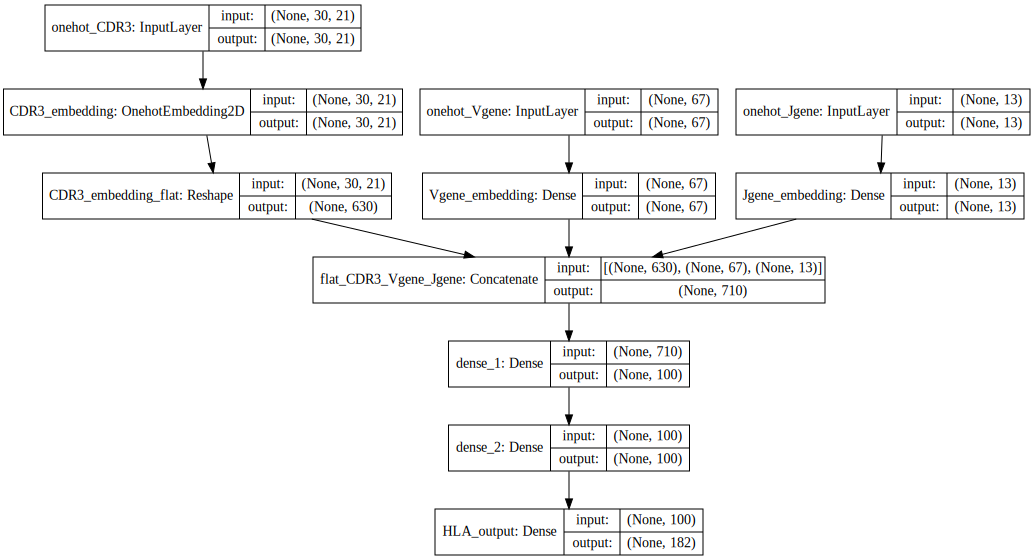

In [709]:
################# Simple classifier:
# Building the layers:
input_CDR3 = Input(shape=input_shape[0], name='onehot_CDR3')
input_Vgene = Input(shape=input_shape[1], name='onehot_Vgene')
input_Jgene = Input(shape=input_shape[2], name='onehot_Jgene')

embedding_CDR3 = OnehotEmbedding2D(embedding_output_dim[0], name='CDR3_embedding')(input_CDR3)
AA_embedding = Model(input_CDR3, embedding_CDR3)
embedding_CDR3_flat = Reshape([embedding_output_dim[0] * MAX_LEN], name='CDR3_embedding_flat')(embedding_CDR3)
embedding_Vgene = Dense(embedding_output_dim[1], name='Vgene_embedding')(input_Vgene)
Vgene_embedding = Model(input_Vgene, embedding_Vgene)
embedding_Jgene = Dense(embedding_output_dim[2], name='Jgene_embedding')(input_Jgene)
Jgene_embedding = Model(input_Jgene, embedding_Jgene)

merged_input = keras.layers.concatenate([embedding_CDR3_flat, embedding_Vgene, embedding_Jgene], name='flat_CDR3_Vgene_Jgene')
dense1 = Dense(100, activation='elu', name='dense_1')(merged_input)
dense2 = Dense(100, activation='elu', name='dense_2')(dense1)
#dense3 = Dense(dense_nodes, activation='elu', name='dense_3')(dense2)
output_HLA = Dense(len(HLA_GENE_SET), activation='softmax', name='HLA_output')(dense2)
#output_HLA = Dense(1, activation='sigmoid', name='HLA_output')(dense2)


nn = Model([input_CDR3, input_Vgene, input_Jgene], output_HLA)
#nn.compile(optimizer="adam", loss='mean_absolute_error')
#nn.compile(optimizer="adam", loss='binary_crossentropy')
nn.compile(optimizer="adam", loss=hla_loss)
nn.summary()
# plot_model(encoder, to_file='encoder.svg', show_shapes=True)
SVG(model_to_dot(nn, show_shapes=True).create(prog='dot', format='svg'))

In [446]:
input_CDR3 = Input(shape=input_shape[0], name='onehot_CDR3')
CDR3_flat = Reshape([embedding_output_dim[0] * MAX_LEN], name='CDR3_embedding_flat')(input_CDR3)
dense1 = Dense(200, activation='elu', name='dense_1')(CDR3_flat)
output_HLA = Dense(1, activation='linear', name='HLA_output')(dense1)
nn = Model(input_CDR3, output_HLA)
nn.compile(optimizer="adam", loss='binary_crossentropy')
#nn.compile(optimizer="adam", loss=hla_loss)
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
onehot_CDR3 (InputLayer)     (None, 30, 21)            0         
_________________________________________________________________
CDR3_embedding_flat (Reshape (None, 630)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               126200    
_________________________________________________________________
HLA_output (Dense)           (None, 1)                 201       
Total params: 126,401
Trainable params: 126,401
Non-trainable params: 0
_________________________________________________________________


In [710]:
use_cache = False
nb_epoch = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
best_weights_filename = "HLA_nn_best.h5"
if not (use_cache and os.path.isfile(best_weights_filename)):
    save_best_weights = ModelCheckpoint(best_weights_filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    vae_log = nn.fit([x_train_CDR3, x_train_Vgene, x_train_Jgene],
#    vae_log = nn.fit(x_train_CDR3,
                     x_train_HLA,
                     shuffle=True,
                     epochs=nb_epoch,
                     batch_size=batch_size,
                     validation_split=0.1,
                     callbacks=[early_stopping, save_best_weights])
nn.load_weights(best_weights_filename)  # Load best weights after early stopping kicks in

Train on 810000 samples, validate on 90000 samples
Epoch 1/100
810000/810000 [==============================] - 77s - loss: 0.0396 - val_loss: 0.0394
Epoch 2/100
810000/810000 [==============================] - 76s - loss: 0.0395 - val_loss: 0.0394
Epoch 3/100
810000/810000 [==============================] - 75s - loss: 0.0395 - val_loss: 0.0394
Epoch 4/100
810000/810000 [==============================] - 76s - loss: 0.0395 - val_loss: 0.0393
Epoch 5/100
810000/810000 [==============================] - 76s - loss: 0.0395 - val_loss: 0.0394
Epoch 6/100
810000/810000 [==============================] - 75s - loss: 0.0395 - val_loss: 0.0396
Epoch 7/100
810000/810000 [==============================] - 75s - loss: 0.0395 - val_loss: 0.0395
Epoch 8/100
810000/810000 [==============================] - 75s - loss: 0.0395 - val_loss: 0.0394
Epoch 9/100
810000/810000 [==============================] - 76s - loss: 0.0395 - val_loss: 0.0394
Epoch 10/100
810000/810000 [==============================

In [187]:
nn.load_weights(best_weights_filename)  # Load best weights after early stopping kicks in
# Save/load trained weights:
#vae.save('two_layer_vae.h5')
#vae.load_weights('two_layer_vae.h5')

In [711]:
# Let's look at the loss on the train vs. the hold out test set:
trainset_loss = nn.evaluate(x=[x_train_CDR3, x_train_Vgene, x_train_Jgene], y=x_train_HLA, batch_size=batch_size)
testset_loss = nn.evaluate(x=[x_test_CDR3, x_test_Vgene, x_test_Jgene], y=x_test_HLA, batch_size=batch_size)
print('# Sum of losses #\nTrain set: {:.8f}\nTest set: {:.8f}'.format(float(trainset_loss), float(testset_loss)))

 99300/100000 [============================>.] - ETA: 0s# Sum of losses #
Train set: 0.03941144
Test set: 0.03942268


In [497]:
# Let's look at the loss on the train vs. the hold out test set:
trainset_loss = nn.evaluate(x=x_train_CDR3, y=x_train_HLA, batch_size=batch_size)
testset_loss = nn.evaluate(x=x_test_CDR3, y=x_test_HLA, batch_size=batch_size)
print('# Sum of losses #\nTrain set: {:.8f}\nTest set: {:.8f}'.format(float(trainset_loss), float(testset_loss)))

In [712]:
test_predict = nn.predict(x=[x_test_CDR3, x_test_Vgene, x_test_Jgene], batch_size=batch_size)

In [655]:
x_test_HLA[test_predict.argmax()]

array([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [656]:
x_test_HLA[test_predict.argmin()]

IndexError: index 782010 is out of bounds for axis 0 with size 10000

In [696]:
sorted(test_predict[0])

[1.1215372e-13,
 1.73615e-13,
 3.4081627e-13,
 4.7748296e-13,
 5.2502897e-13,
 5.557736e-13,
 7.1992586e-13,
 1.0879899e-12,
 1.1181481e-12,
 1.1202999e-12,
 1.2022113e-12,
 1.2533633e-12,
 1.3987212e-12,
 1.7363265e-12,
 1.8221065e-12,
 1.9156397e-12,
 1.9276542e-12,
 2.122386e-12,
 2.1800853e-12,
 2.1956885e-12,
 2.208537e-12,
 2.349254e-12,
 2.378352e-12,
 2.4638434e-12,
 2.529643e-12,
 3.016151e-12,
 3.1103273e-12,
 3.1465464e-12,
 3.3556968e-12,
 3.372521e-12,
 3.4310382e-12,
 3.473423e-12,
 3.4899518e-12,
 3.752823e-12,
 3.76634e-12,
 3.7961257e-12,
 4.2335276e-12,
 4.2553773e-12,
 4.276516e-12,
 4.4076414e-12,
 4.545465e-12,
 4.556602e-12,
 4.6431335e-12,
 4.680121e-12,
 5.183357e-12,
 5.1844744e-12,
 5.228606e-12,
 5.3404334e-12,
 5.548873e-12,
 5.645045e-12,
 6.1530178e-12,
 6.3086593e-12,
 6.677114e-12,
 7.1226384e-12,
 7.278708e-12,
 7.541798e-12,
 8.005449e-12,
 8.16082e-12,
 8.588576e-12,
 8.776817e-12,
 9.22628e-12,
 9.644358e-12,
 1.0802159e-11,
 1.086597e-11,
 1.1468064

In [713]:
test_predict.argmax(axis=-1)[0:100]

array([88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88])

In [714]:
np.random.shuffle(x_train_HLA)
np.random.shuffle(x_test_HLA)

In [715]:
# Let's look at the loss on the train vs. the hold out test set:
trainset_loss = nn.evaluate(x=[x_train_CDR3, x_train_Vgene, x_train_Jgene], y=x_train_HLA, batch_size=batch_size)
testset_loss = nn.evaluate(x=[x_test_CDR3, x_test_Vgene, x_test_Jgene], y=x_test_HLA, batch_size=batch_size)
print('# Sum of losses #\nTrain set: {:.8f}\nTest set: {:.8f}'.format(float(trainset_loss), float(testset_loss)))

 99700/100000 [============================>.] - ETA: 0s# Sum of losses #
Train set: 0.03941508
Test set: 0.03942374


In [452]:
# Let's look at the loss on the train vs. the hold out test set:
trainset_loss = nn.evaluate(x=x_train_CDR3, y=x_train_HLA, batch_size=batch_size)
testset_loss = nn.evaluate(x=x_test_CDR3, y=x_test_HLA, batch_size=batch_size)
print('# Sum of losses #\nTrain set: {:.8f}\nTest set: {:.8f}'.format(float(trainset_loss), float(testset_loss)))

 9300/10000 [==========================>...] - ETA: 0s# Sum of losses #
Train set: 0.30097019
Test set: 0.30061954


In [498]:
x_train_HLA.mean()

0.30004445

In [499]:
x_test_HLA.mean()

0.3004

In [533]:
test_predict = nn.predict(x=[x_test_CDR3, x_test_Vgene, x_test_Jgene], batch_size=batch_size)

In [536]:
test_predict

array([[0.28994328],
       [0.27053648],
       [0.2794925 ],
       ...,
       [0.28222603],
       [0.28182745],
       [0.28936827]], dtype=float32)

In [562]:
print(test_predict.max())
print(test_predict.min())

0.36244965
0.25377244


In [501]:
d = test_predict - x_test_HLA

In [502]:
d.shape

(10000, 1)

In [509]:
np.abs(d).mean()

0.30042967

In [510]:
np.abs(test_predict - x_test_HLA).mean()

0.30042967

In [188]:
x_train_HLA[0]

array([0.   , 0.125, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.125, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.125, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.125, 0.   , 0.125, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.125, 0.   , 0.   , 0.   , 0.   , 0.125, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.125, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   ], dtype=float32)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
onehot_CDR3 (InputLayer)         (None, 30, 21)        0                                            
____________________________________________________________________________________________________
CDR3_embedding (OnehotEmbedding2 (None, 30, 10)        210         onehot_CDR3[0][0]                
____________________________________________________________________________________________________
onehot_Vgene (InputLayer)        (None, 67)            0                                            
____________________________________________________________________________________________________
onehot_Jgene (InputLayer)        (None, 13)            0                                            
___________________________________________________________________________________________

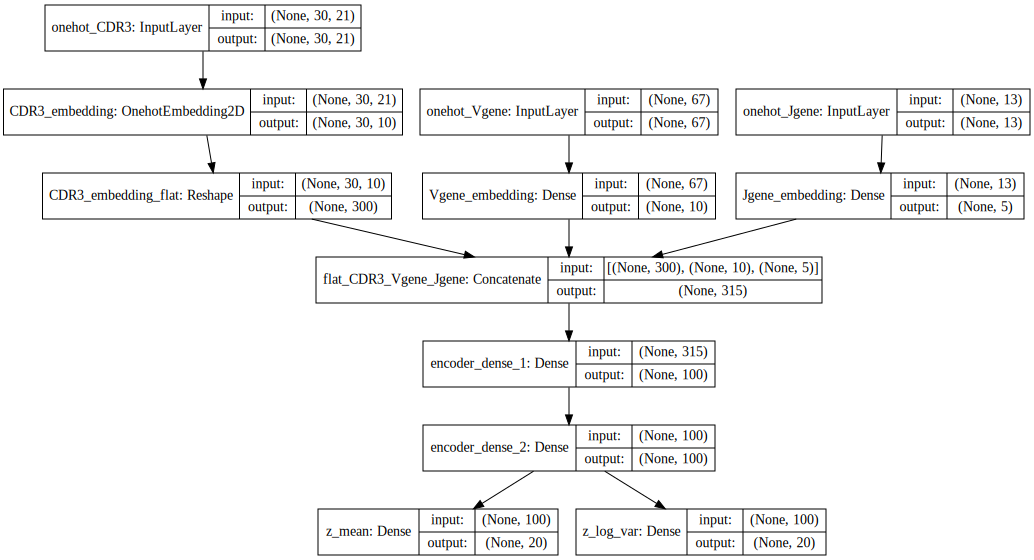

In [98]:
# Encoding layers:
encoder_input_CDR3 = Input(shape=input_shape[0], name='onehot_CDR3')
encoder_input_Vgene = Input(shape=input_shape[1], name='onehot_Vgene')
encoder_input_Jgene = Input(shape=input_shape[2], name='onehot_Jgene')

embedding_CDR3 = OnehotEmbedding2D(embedding_output_dim[0], name='CDR3_embedding')(encoder_input_CDR3)
AA_embedding = Model(encoder_input_CDR3, embedding_CDR3)
embedding_CDR3_flat = Reshape([embedding_output_dim[0] * MAX_LEN], name='CDR3_embedding_flat')(embedding_CDR3)
embedding_Vgene = Dense(embedding_output_dim[1], name='Vgene_embedding')(encoder_input_Vgene)
Vgene_embedding = Model(encoder_input_Vgene, embedding_Vgene)
embedding_Jgene = Dense(embedding_output_dim[2], name='Jgene_embedding')(encoder_input_Jgene)
Jgene_embedding = Model(encoder_input_Jgene, embedding_Jgene)


merged_input = keras.layers.concatenate([embedding_CDR3_flat, embedding_Vgene, embedding_Jgene], name='flat_CDR3_Vgene_Jgene')
dense_encoder1 = Dense(dense_nodes, activation='elu', name='encoder_dense_1')(merged_input)
dense_encoder2 = Dense(dense_nodes, activation='elu', name='encoder_dense_2')(dense_encoder1)

# Latent layers:
z_mean = Dense(latent_dim, name='z_mean')(dense_encoder2)
z_log_var = Dense(latent_dim, name='z_log_var')(dense_encoder2)

encoder = Model([encoder_input_CDR3, encoder_input_Vgene, encoder_input_Jgene], [z_mean, z_log_var])
encoder.summary()
# plot_model(encoder, to_file='encoder.svg', show_shapes=True)
SVG(model_to_dot(encoder, show_shapes=True).create(prog='dot', format='svg'))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 20)            0                                            
____________________________________________________________________________________________________
decoder_dense_1 (Dense)          (None, 100)           2100        input_1[0][0]                    
                                                                   input_1[0][0]                    
                                                                   input_1[0][0]                    
____________________________________________________________________________________________________
decoder_dense_2 (Dense)          (None, 100)           10100       decoder_dense_1[3][0]            
                                                                   decoder_dense_1[4][0]   

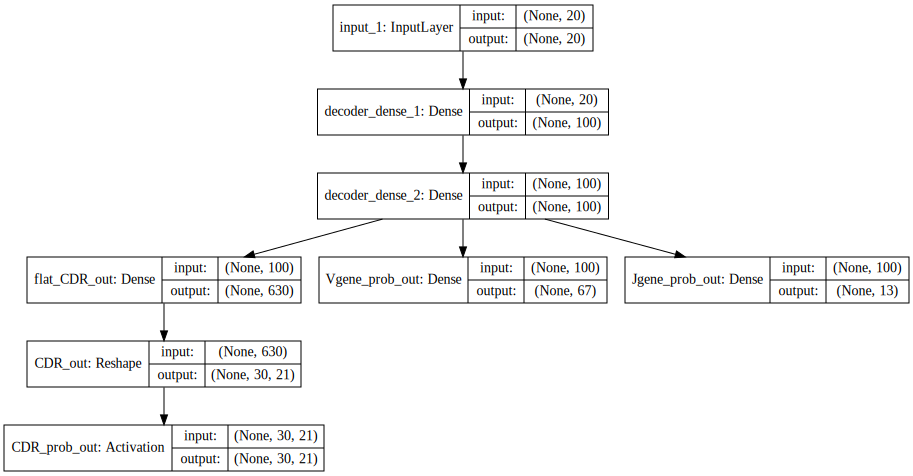

In [99]:
# Decoding layers:
z = Lambda(sampling, output_shape=(latent_dim, ), name='reparameterization_trick')  # This is the reparameterization trick
dense_decoder1 = Dense(dense_nodes, activation='elu', name='decoder_dense_1')
dense_decoder2 = Dense(dense_nodes, activation='elu', name='decoder_dense_2')

decoder_out_CDR3 = Dense(np.array(input_shape[0]).prod(), activation='linear', name='flat_CDR_out')
reshape_CDR3 = Reshape(input_shape[0], name='CDR_out')
position_wise_softmax_CDR3 = Activation(activation='softmax', name='CDR_prob_out')
decoder_out_Vgene = Dense(input_shape[1][0], activation='softmax', name='Vgene_prob_out')
decoder_out_Jgene = Dense(input_shape[2][0], activation='softmax', name='Jgene_prob_out')

decoder_output_CDR3 = position_wise_softmax_CDR3(reshape_CDR3(decoder_out_CDR3(dense_decoder2(dense_decoder1(z([z_mean, z_log_var]))))))
decoder_output_Vgene = decoder_out_Vgene(dense_decoder2(dense_decoder1(z([z_mean, z_log_var]))))
decoder_output_Jgene = decoder_out_Jgene(dense_decoder2(dense_decoder1(z([z_mean, z_log_var]))))

# Define the decoding part separately:
z_mean_generator = Input(shape=(latent_dim,))
decoder_generator_CDR3 = position_wise_softmax_CDR3(reshape_CDR3(decoder_out_CDR3(dense_decoder2(dense_decoder1(z_mean_generator)))))
decoder_generator_Vgene = decoder_out_Vgene(dense_decoder2(dense_decoder1(z_mean_generator)))
decoder_generator_Jgene = decoder_out_Jgene(dense_decoder2(dense_decoder1(z_mean_generator)))

decoder = Model(z_mean_generator, [decoder_generator_CDR3, decoder_generator_Vgene, decoder_generator_Jgene])
decoder.summary()
# plot_model(decoder, to_file='decoder.svg', show_shapes=True)
SVG(model_to_dot(decoder, show_shapes=True).create(prog='dot', format='svg'))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
onehot_CDR3 (InputLayer)         (None, 30, 21)        0                                            
____________________________________________________________________________________________________
CDR3_embedding (OnehotEmbedding2 (None, 30, 10)        210         onehot_CDR3[0][0]                
____________________________________________________________________________________________________
onehot_Vgene (InputLayer)        (None, 67)            0                                            
____________________________________________________________________________________________________
onehot_Jgene (InputLayer)        (None, 13)            0                                            
___________________________________________________________________________________________

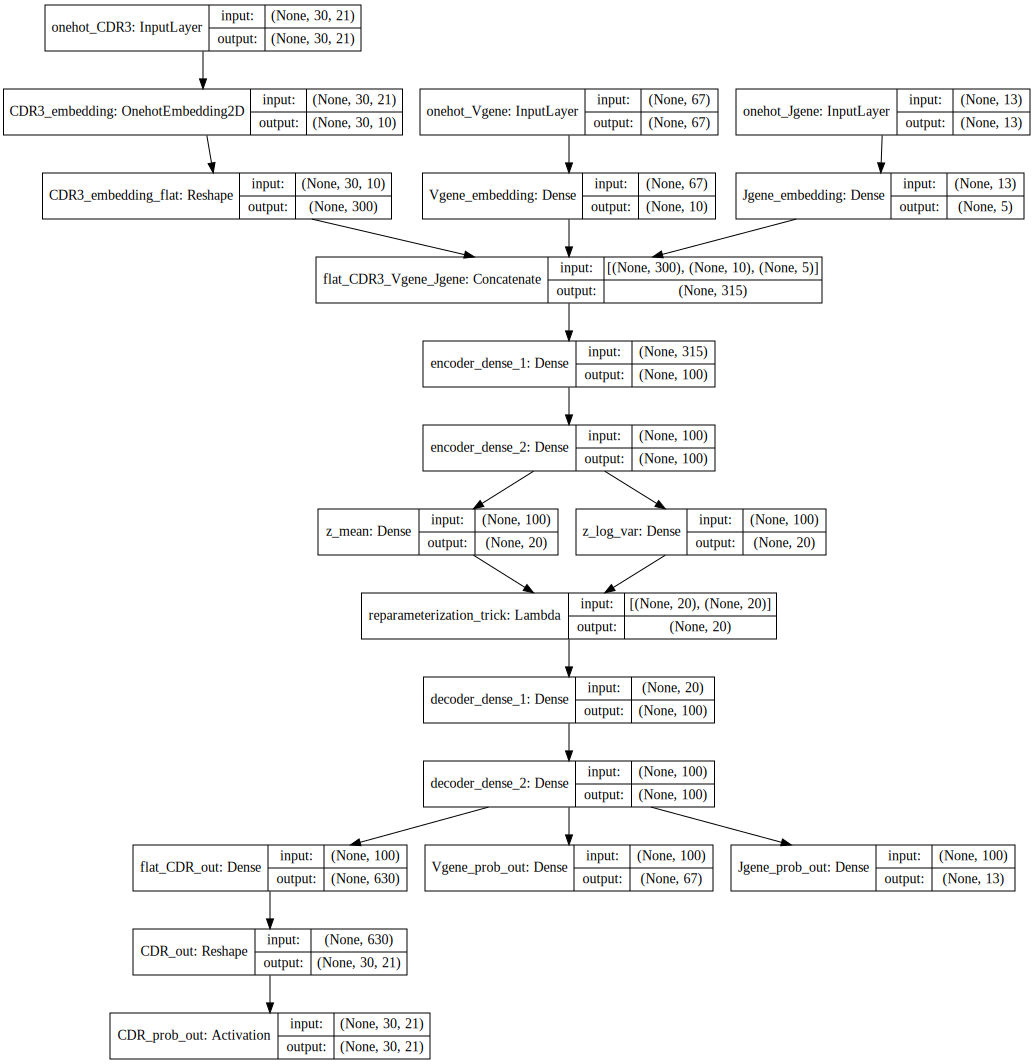

In [101]:
vae = Model([encoder_input_CDR3, encoder_input_Vgene, encoder_input_Jgene], [decoder_output_CDR3, decoder_output_Vgene, decoder_output_Jgene])
vae.compile(optimizer="adam", loss=vae_loss)
vae.summary()
#vae.save('two_layer_vae_TCR_init.h5')
plot_model(vae, to_file='vae_TCR.svg', show_shapes=True)
SVG(model_to_dot(vae, show_shapes=True).create(prog='dot', format='svg'))

In [102]:
nb_epoch = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
best_weights_filename = "cached_weights_TCR_vae/two_layer_dense_vae-TCR_weights_best_CMV.h5"
if not os.path.isfile(best_weights_filename):
    save_best_weights = ModelCheckpoint(best_weights_filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    vae_log = vae.fit([x_train_CDR3, x_train_Vgene, x_train_Jgene],
                      [x_train_CDR3, x_train_Vgene, x_train_Jgene],  # VAE is unsupervised so y=X
                      shuffle=True,
                      epochs=nb_epoch,
                      batch_size=batch_size,
                      validation_split=0.1,
                      callbacks=[early_stopping, save_best_weights])
vae.load_weights(best_weights_filename)  # Load best weights after early stopping kicks in

In [795]:
vae.load_weights(best_weights_filename)  # Load best weights after early stopping kicks in
# Save/load trained weights:
#vae.save('two_layer_vae.h5')
#vae.load_weights('two_layer_vae.h5')

In [103]:
# Encode the train/test set into latent space:
x_train_encoded = encoder.predict([x_train_CDR3, x_train_Vgene, x_train_Jgene])
x_train_encoded = x_train_encoded[0]

x_test_encoded = encoder.predict([x_test_CDR3, x_test_Vgene, x_test_Jgene])
x_test_encoded = x_test_encoded[0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
HLA_output (Dense)           (None, 259)               26159     
Total params: 38,359
Trainable params: 38,359
Non-trainable params: 0
_________________________________________________________________


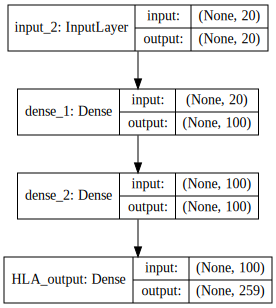

In [104]:
################# Classifier on VAE encodings:
# Building the layers:
input_encodings = Input(shape=[x_train_encoded.shape[1]])

dense1 = Dense(100, activation='elu', name='dense_1')(input_encodings)
dense2 = Dense(100, activation='elu', name='dense_2')(dense1)
#dense3 = Dense(dense_nodes, activation='elu', name='dense_3')(dense2)
output_HLA = Dense(len(HLA_GENE_SET), activation='softmax', name='HLA_output')(dense2)


nn = Model(input_encodings, output_HLA)
nn.compile(optimizer="adam", loss='mean_absolute_error')
#nn.compile(optimizer="adam", loss=hla_loss)
nn.summary()
# plot_model(encoder, to_file='encoder.svg', show_shapes=True)
SVG(model_to_dot(nn, show_shapes=True).create(prog='dot', format='svg'))

In [105]:
use_cache = False
nb_epoch = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
best_weights_filename = "HLA_nn_best.h5"
if not (use_cache and os.path.isfile(best_weights_filename)):
    save_best_weights = ModelCheckpoint(best_weights_filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    vae_log = nn.fit(x_train_encoded,
                      x_train_HLA,
                      shuffle=True,
                      epochs=nb_epoch,
                      batch_size=batch_size,
                      validation_split=0.1,
                      callbacks=[early_stopping, save_best_weights])
nn.load_weights(best_weights_filename)  # Load best weights after early stopping kicks in

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
81000/81000 [==============================] - 4s - loss: nan - val_loss: nan
Epoch 2/100
66400/81000 [=======================>......] - ETA: 0s - loss: nan

KeyboardInterrupt: 

In [857]:
nn.load_weights(best_weights_filename)  # Load best weights after early stopping kicks in
# Save/load trained weights:
#vae.save('two_layer_vae.h5')
#vae.load_weights('two_layer_vae.h5')

In [858]:
# Let's look at the loss on the train vs. the hold out test set:
trainset_loss = nn.evaluate(x=x_train_encoded, y=x_train_HLA, batch_size=batch_size)
testset_loss = nn.evaluate(x=x_test_encoded, y=x_test_HLA, batch_size=batch_size)
print('# Sum of losses #\nTrain set: {:.8f}\nTest set: {:.8f}'.format(float(trainset_loss), float(testset_loss)))

34400/36000 [===========================>..] - ETA: 0s# Sum of losses #
Train set: 0.04675937
Test set: 0.04685160


In [859]:
HLA_test_pred = nn.predict(x_test_encoded)

In [860]:
HLA_test_pred.shape

(36000, 31)

In [861]:
HLA_test_pred[1]

array([8.4831163e-02, 1.9785970e-01, 2.1093112e-01, 3.4081896e-07,
       2.3594087e-07, 3.1115931e-02, 3.3223753e-07, 7.1952314e-07,
       5.5829071e-07, 4.6480767e-07, 4.1093642e-07, 3.7178302e-07,
       3.9834339e-07, 2.8891739e-07, 2.2058524e-01, 1.7495915e-04,
       2.3860053e-07, 4.0681914e-07, 3.2011181e-07, 4.9991576e-07,
       3.3122868e-07, 1.3769591e-02, 2.9869187e-07, 3.3241821e-07,
       3.9931214e-07, 2.4072297e-01, 8.2858554e-07, 3.2979480e-07,
       4.5562928e-07, 3.5968080e-07, 3.2460102e-07], dtype=float32)

In [862]:
x_test_HLA[10]

array([0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  ],
      dtype=float32)

In [863]:
i = 10
for i in range(20):
    print(i, HLA_test_pred[i][x_test_HLA[i] != 0 + False], [HLA_DICT_REV[i] for i, t in enumerate(x_test_HLA[i] != 0) if t])

0 [1.9936053e-01 1.9103070e-06 3.3456908e-04 5.7633736e-07] ['HLA-A*01', 'HLA-A*26', 'HLA-B*08', 'HLA-B*38']
1 [1.9785970e-01 3.1115931e-02 1.7495915e-04 8.2858554e-07] ['HLA-A*02', 'HLA-A*24', 'HLA-B*08', 'HLA-B*51']
2 [0.22233106 0.20573904 0.16765971 0.00056573] ['HLA-A*01', 'HLA-A*02', 'HLA-B*07', 'HLA-B*08']
3 [6.6644373e-07 1.3901860e-06 1.7307352e-01 5.3165354e-07] ['HLA-A*23', 'HLA-A*29', 'HLA-B*07', 'HLA-B*38']
4 [6.5372273e-02 8.1868978e-07 2.1222629e-02 8.2908321e-07] ['HLA-A*24', 'HLA-A*32', 'HLA-B*35', 'HLA-B*62']
5 [9.9477328e-02 2.3581879e-01 5.6695630e-08 1.8326688e-01] ['HLA-A*01', 'HLA-A*03', 'HLA-B*15', 'HLA-B*44']
6 [1.4570771e-01 2.4327906e-05 1.5312802e-02 1.3547488e-01] ['HLA-A*24', 'HLA-A*32', 'HLA-B*35', 'HLA-B*44']
7 [1.7775829e-01 2.8958718e-07 2.2152122e-04 3.3147390e-07] ['HLA-A*01', 'HLA-A*32', 'HLA-B*08', 'HLA-B*60']
8 [3.6136489e-02 5.9653523e-08 1.1213777e-07 1.9558741e-01] ['HLA-A*24', 'HLA-A*68', 'HLA-B*18', 'HLA-B*44']
9 [2.1036738e-01 2.5013028e-02 

In [864]:
min_max = dict()
for i in range(10000):
    for val, allele in zip(HLA_test_pred[i][x_test_HLA[i] != 0 + False], [HLA_DICT_REV[i] for i, t in enumerate(x_test_HLA[i] != 0) if t]):
        if allele not in min_max:
            min_max[allele] = [val, val]
        elif min(min_max[allele]) > val:
            min_max[allele][0] = val
        elif max(min_max[allele]) < val:
            min_max[allele][1] = val
        else:
            pass


In [865]:
min_max

{'HLA-A*01': [0.059854537, 0.2750385],
 'HLA-A*02': [0.17463529, 0.23597136],
 'HLA-A*03': [0.1607221, 0.2483197],
 'HLA-A*11': [3.084193e-08, 4.8491333e-05],
 'HLA-A*23': [2.04005e-08, 4.3283308e-05],
 'HLA-A*24': [0.0123661, 0.22180976],
 'HLA-A*25': [2.5896917e-08, 1.6661803e-05],
 'HLA-A*26': [6.975042e-08, 4.200662e-05],
 'HLA-A*29': [4.82298e-08, 4.5321354e-05],
 'HLA-A*30': [4.2918764e-08, 2.1541195e-05],
 'HLA-A*31': [4.1362412e-08, 2.5589337e-05],
 'HLA-A*32': [3.420646e-08, 5.666022e-05],
 'HLA-A*33': [3.956423e-08, 2.1765683e-05],
 'HLA-A*68': [1.9204737e-08, 3.690877e-05],
 'HLA-B*07': [0.14977124, 0.24995896],
 'HLA-B*08': [5.5660465e-05, 0.0021766988],
 'HLA-B*13': [2.2133365e-08, 3.635624e-05],
 'HLA-B*14': [3.697844e-08, 2.0100348e-05],
 'HLA-B*15': [3.3093386e-08, 8.534405e-06],
 'HLA-B*18': [5.0452925e-08, 2.8889392e-05],
 'HLA-B*27': [2.281926e-08, 4.872808e-05],
 'HLA-B*35': [0.0042848634, 0.14739606],
 'HLA-B*38': [1.7660426e-08, 1.4943107e-05],
 'HLA-B*39': [3.858

In [846]:
# Encode a chunk of testset data into latent space:
chunk = 10000
x_test_encoded = encoder.predict([x_test_CDR3[0:chunk], x_test_Vgene[0:chunk], x_test_Jgene[0:chunk]])
print('Output shape: [{}, {}]'.format(x_test_encoded[0].shape, x_test_encoded[0].shape))

Output shape: [(10000, 20), (10000, 20)]


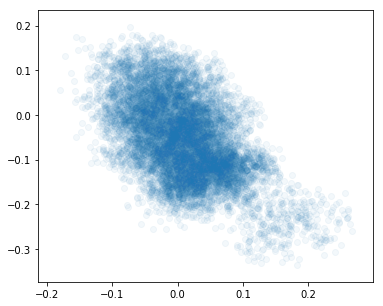

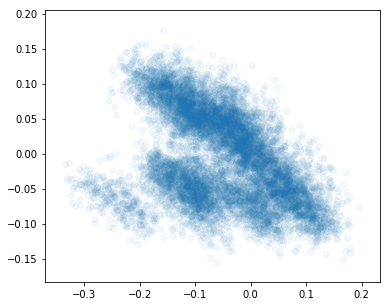

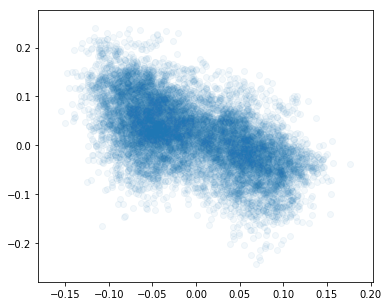

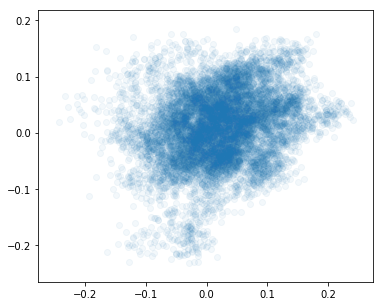

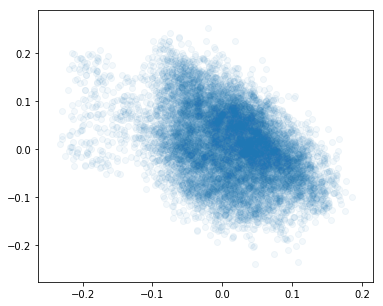

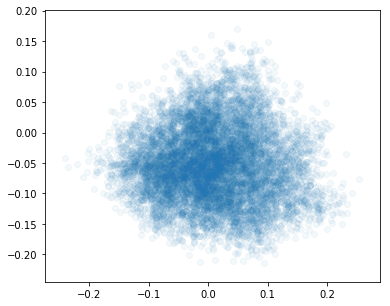

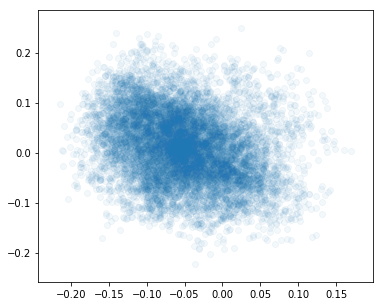

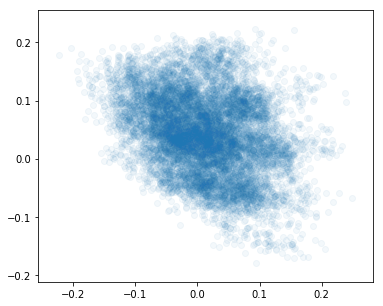

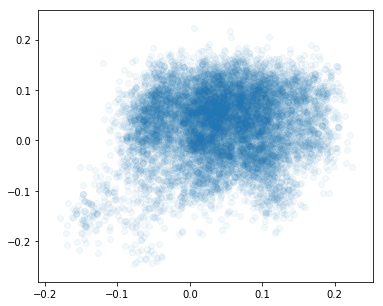

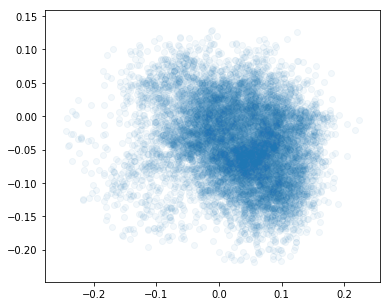

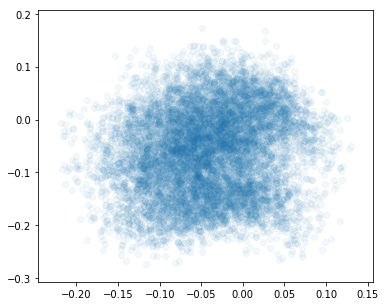

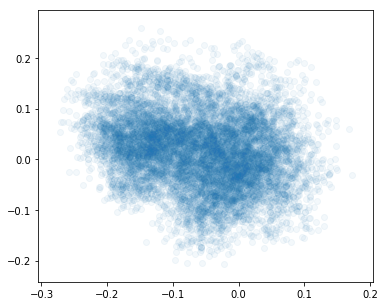

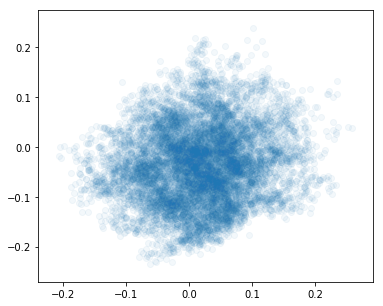

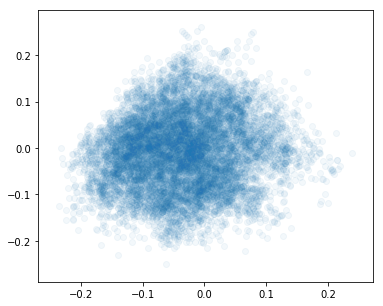

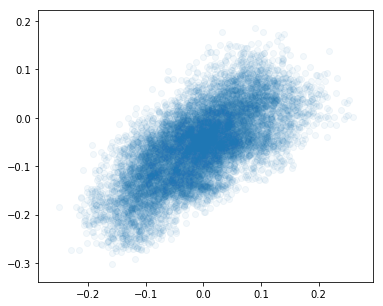

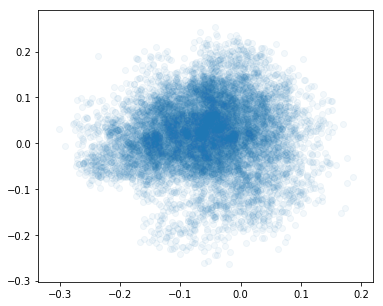

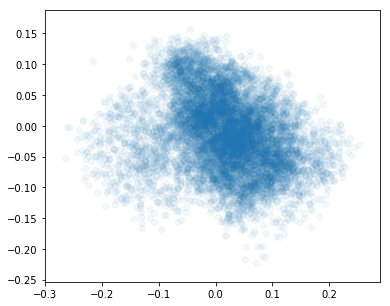

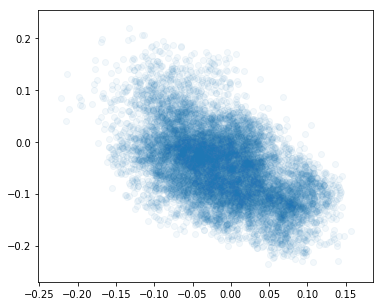

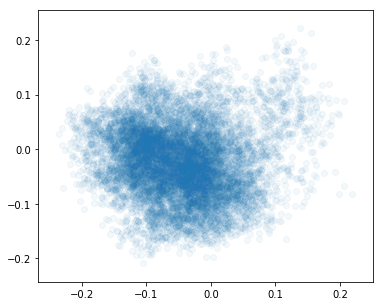

In [847]:
# Take a quick look at the latent space:
for i in range(19):
    x = list(x_test_encoded[0][:, i])
    y = list(x_test_encoded[0][:, i+1])
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, alpha=0.05);

In [848]:
# Do a PCA to see how much explained variance that can be extracted
# from any two dimensional combination of the latent space:
pca = PCA(n_components=2)
pca.fit(x_test_encoded[0])
print('PCA total explained variance in two dimensions is {:.3}%'.format(pca.explained_variance_ratio_.sum() * 100))

PCA total explained variance in two dimensions is 43.1%


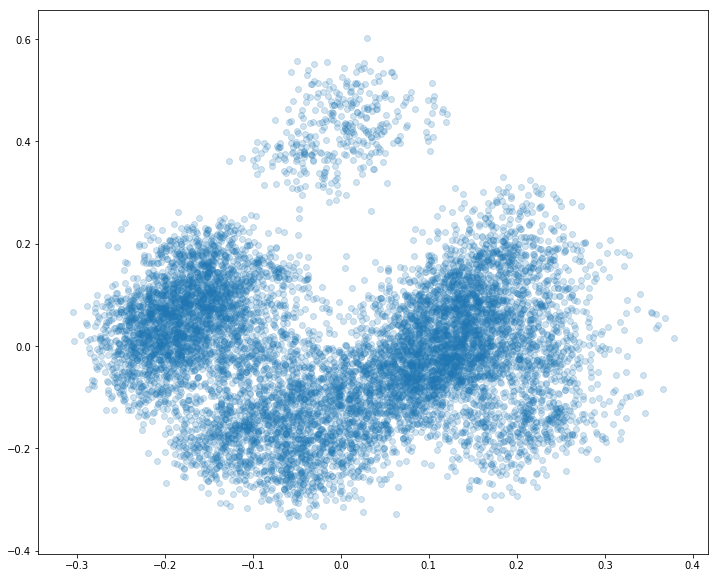

In [849]:
# Plot the PCA results:
X_r = pca.fit(x_test_encoded[0]).transform(x_test_encoded[0])
plt.figure(figsize=(12, 10))
x = list(X_r[:,0])
y = list(X_r[:, 1])
plt.scatter(x, y, alpha=0.2);

In [850]:
# Decode the chunk of testdata from latent space into the original input space:
x_test_CDR3_decoded, x_test_Vgene_decoded, x_test_Jgene_decoded = decoder.predict(x_test_encoded[0])

In [851]:
# The softmax activation on the last layer should bound the sum of each position to 1.
# This enable us to intepret the values as probabilities.
print('The sum of character probabilities at position one is: {}'.format(str(sum(x_test_CDR3_decoded[0][0]))))
print('The sum of probabilities at all {} positions is: {}'.format(str(x_test_CDR3_decoded.shape[1]), str(sum(sum(x_test_CDR3_decoded[0])))))

The sum of character probabilities at position one is: 1.000000011175871
The sum of probabilities at all 30 positions is: 29.999998927116394


In [852]:
# Then translate the onehot encoding to a sequence:
TCRb_test = onehot2TCRbeta(x_test_CDR3[0:chunk], x_test_Vgene[0:chunk], x_test_Jgene[0:chunk])
TCRb_test_decoded = onehot2TCRbeta(x_test_CDR3_decoded, x_test_Vgene_decoded, x_test_Jgene_decoded)

In [853]:
# Compare the input sequences with those that have been a roundtrip through the VAE:
mismatches = 0
print('First line is the input sequence.\nSecond line is the VAE output.\nThird line is the amino acid identity for the input sequence in case of disagreements.\nFourth line is the amino acid identity for the VAE output in case of disagreements.\n')
for i in range(100):
    y = list(TCRb_test[i][0]) + [' ']*5 + [TCRb_test[i][1]] + [' ']*5 + [TCRb_test[i][2]]
    p = list(TCRb_test_decoded[i][0]) + [' ']*5 + [TCRb_test_decoded[i][1]] + [' ']*5 + [TCRb_test_decoded[i][2]]
    print(''.join(y))
    print(''.join(p))
    print('{}'.format(''.join([' ' if i==j else '*'*len(i) for i,j in zip(y, p)])))
    print()
    mismatches += sum(0 if i==j else 1 for i,j in zip(y, p))
print('\nTotal disagreements: {}'.format(mismatches))

First line is the input sequence.
Second line is the VAE output.
Third line is the amino acid identity for the input sequence in case of disagreements.
Fourth line is the amino acid identity for the VAE output in case of disagreements.

CVRSFRD---------------NITDEQYF     TCRBV07-05     TCRBJ02-07
YAT-STSG-YNKRMPEQINAGTVRQGCSDA     TCRBV05-05     TCRBJ02-06
******** *********************     **********     **********

CSSSLG-----------------SQETQYF     TCRBV07-09     TCRBJ02-05
THTFNTLY-WKPEKKVQERPYYPWCRDIGA     TCRBV27-01     TCRBJ02-04
******** *********************     **********     **********

CASSPRT---------------GDWNEQYF     TCRBV05-01     TCRBJ02-07
YFRCASMGENNSRMPHVIETQQQMHLHSDD     TCRBV20-or09_02     TCRBJ02-02
******************************     **********     **********

CASSPG-----------------QGHEQYF     TCRBV13-01     TCRBJ02-07
MQT-QELA-YFLQ-PQVCPTGT-REIHSDA     TCRBV20-or09_02     TCRBJ02-04
******** **** ******** *******     **********     **********

CASSVGW----------

In [36]:
# Sample from the latent space to generate new TCR betas:
lsample = np.random.normal(0, 1, size=(batch_size * 10000, latent_dim))
vae_sample_CDR3, vae_sample_Vgene, vae_sample_Jgene = decoder.predict(lsample)
vae_sample_TCRb = onehot2TCRbeta(vae_sample_CDR3, vae_sample_Vgene, vae_sample_Jgene)

In [37]:
for i in range(100):
    y = list(vae_sample_TCRb[i][0]) + [' ']*5 + [vae_sample_TCRb[i][1]] + [' ']*5 + [vae_sample_TCRb[i][2]]
    print(''.join(y))

CASQEG-----------------KNQELFF     TCRBV05-05     TCRBJ02-02
CASSSWP----------------SSQTQYF     TCRBV11-02     TCRBJ02-05
CASSSPA---------------GILDGQFF     TCRBV10-03     TCRBJ02-01
CASSLP-----------------FRYEQYF     TCRBV09-01     TCRBJ02-05
CASSLFN---------------TVYDTQYF     TCRBV04-03     TCRBJ02-03
CASLSA-----------------TYNELFF     TCRBV18-01     TCRBJ02-02
CASSFKQ----------------PYGELFF     TCRBV25-01     TCRBJ02-02
CASSPNRL--------------FGLYGQYF     TCRBV04-01     TCRBJ02-04
CASSVDD----------------SYYEQYF     TCRBV27-01     TCRBJ02-07
CARSSSA----------------EGNTQYF     TCRBV10-02     TCRBJ02-03
CASSSRF----------------YYYEAFF     TCRBV30-01     TCRBJ01-01
CASSPS-----------------APGEAFF     TCRBV27-01     TCRBJ01-01
CAPSLHS----------------FRTEQYF     TCRBV07-09     TCRBJ02-07
CASSTR-----------------GYDEQYF     TCRBV05-07     TCRBJ02-07
CASIDHHH--------------RGHDTQYF     TCRBV05-03     TCRBJ02-03
CASTLR-----------------MWAEQFF     TCRBV02-01     TCRBJ02-01
CASKSKR----------------R